# News Confidence Gating

Not all news days are equal. Create a confidence score per stock/day and use it to:
- Trade only when confidence > threshold
- Or size positions proportionally to confidence

**Confidence Score Components:**
1. Number of news items (more news = more signal)
2. Embedding norm magnitude (stronger embedding = clearer signal)
3. Agreement between news and fundamentals signals

This typically cuts losers without killing winners.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load Data and Model

In [2]:
# Load dataset
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

# Time-based split - use test set (last 15% of dates)
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
val_end_idx = int(n_dates * 0.85)
test_dates = set(dates[val_end_idx:])

test_df = df[df["feature_date"].isin(test_dates)].copy()

print(f"Test set: {len(test_df):,} rows")
print(f"Date range: {test_df['feature_date'].min().date()} to {test_df['feature_date'].max().date()}")
print(f"Trading days: {test_df['feature_date'].nunique()}")

Test set: 352,213 rows
Date range: 2025-02-11 to 2025-12-18
Trading days: 178


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from dataclasses import dataclass

# Must define ModelConfig before loading checkpoint (needed for unpickling)
@dataclass
class ModelConfig:
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    fundamental_dropout: float = 0.2
    price_dropout: float = 0.2
    news_dropout: float = 0.3
    news_alpha: float = 0.8
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    n_epochs: int = 10
    max_pairs_per_symbol: int | None = None

# Must define model architecture before loading (needed for state_dict)
class MultiBranchRanker(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, 64),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(64, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, 32),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(32, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(128, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)
    
    def get_branch_scores(self, price, fund, emb):
        """Get individual branch contributions for agreement analysis."""
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        return h_f, h_p, h_n

# Load model checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("data/model_single_pair_sharpe9.pt", weights_only=False)

# Extract config and feature columns from checkpoint
config = checkpoint["config"]
price_feat_cols = checkpoint["price_cols"]
fund_feat_cols = checkpoint["fund_cols"]
emb_cols = checkpoint["emb_cols"]

print(f"Loaded checkpoint with pair_cap={checkpoint.get('pair_cap', 'N/A')}")
print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

# Create and load model
model = MultiBranchRanker(config).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"\nLoaded model with {sum(p.numel() for p in model.parameters()):,} parameters")

Loaded checkpoint with pair_cap=N/A
Price features: 9
Fundamental features: 19
Embedding dims: 768

Loaded model with 109,393 parameters


In [22]:
# Feature columns already loaded from checkpoint above
# Verify they match the dataset
print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

# Verify all columns exist in test data
missing_price = [c for c in price_feat_cols if c not in test_df.columns]
missing_fund = [c for c in fund_feat_cols if c not in test_df.columns]
missing_emb = [c for c in emb_cols if c not in test_df.columns]

if missing_price or missing_fund or missing_emb:
    print(f"WARNING: Missing columns!")
    print(f"  Price: {missing_price}")
    print(f"  Fund: {missing_fund}")
    print(f"  Emb: {len(missing_emb)} missing")
else:
    print("All feature columns found in dataset")

Price features: 9
Fundamental features: 19
Embedding dims: 768
All feature columns found in dataset


In [23]:
class PointwiseDataset(Dataset):
    def __init__(self, df, price_cols, fund_cols, emb_cols):
        self.price_arr = df[price_cols].values.astype(np.float32)
        self.fund_arr = df[fund_cols].values.astype(np.float32)
        self.emb_arr = df[emb_cols].values.astype(np.float32)
    
    def __len__(self):
        return len(self.price_arr)
    
    def __getitem__(self, idx):
        return {
            "price": torch.tensor(self.price_arr[idx]),
            "fund": torch.tensor(self.fund_arr[idx]),
            "emb": torch.tensor(self.emb_arr[idx]),
        }

@torch.no_grad()
def get_scores(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    model.eval()
    dataset = PointwiseDataset(df, price_cols, fund_cols, emb_cols)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    scores = []
    for batch in tqdm(loader, desc="Scoring", leave=False):
        price = batch["price"].to(device)
        fund = batch["fund"].to(device)
        emb = batch["emb"].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    return np.concatenate(scores)

# Score test data
test_df["score"] = get_scores(model, test_df, price_feat_cols, fund_feat_cols, emb_cols, device)
print(f"Scored {len(test_df):,} rows")

Scoring:   0%|          | 0/344 [00:00<?, ?it/s]

Scored 352,213 rows


## 2. Compute Confidence Scores

In [24]:
# Component 1: News count confidence
# More news = higher confidence (up to a point)
if "news_count_z" in test_df.columns:
    # Use z-scored news count, clip and normalize to [0, 1]
    test_df["conf_news_count"] = test_df["news_count_z"].clip(-2, 3)
    test_df["conf_news_count"] = (test_df["conf_news_count"] - test_df["conf_news_count"].min()) / \
                                  (test_df["conf_news_count"].max() - test_df["conf_news_count"].min())
else:
    # Fallback: use embedding norm as proxy for having news
    test_df["conf_news_count"] = 0.5

print("News count confidence:")
print(test_df["conf_news_count"].describe())

News count confidence:
count    352213.000000
mean          0.103096
std           0.163923
min           0.000000
25%           0.027621
50%           0.039535
75%           0.129970
max           1.000000
Name: conf_news_count, dtype: float64


In [25]:
# Component 2: Embedding norm (L2 magnitude)
# Stronger embedding = clearer/more definitive news signal
emb_matrix = test_df[emb_cols].values.astype(np.float32)
emb_norms = np.linalg.norm(emb_matrix, axis=1)

# Normalize to [0, 1] using percentiles to handle outliers
norm_min, norm_max = np.percentile(emb_norms, [5, 95])
test_df["emb_norm"] = emb_norms
test_df["conf_emb_norm"] = np.clip((emb_norms - norm_min) / (norm_max - norm_min), 0, 1)

print("\nEmbedding norm stats:")
print(f"  Raw norm: mean={emb_norms.mean():.2f}, std={emb_norms.std():.2f}")
print(f"  Confidence: mean={test_df['conf_emb_norm'].mean():.3f}")


Embedding norm stats:
  Raw norm: mean=0.27, std=0.43
  Confidence: mean=0.269


In [26]:
# Component 3: Agreement between news and fundamentals
# Get latent representations from each branch

@torch.no_grad()
def get_branch_latents(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    """Extract latent representations from each branch."""
    model.eval()
    dataset = PointwiseDataset(df, price_cols, fund_cols, emb_cols)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    fund_latents, price_latents, news_latents = [], [], []
    
    for batch in tqdm(loader, desc="Extracting latents", leave=False):
        price = batch["price"].to(device)
        fund = batch["fund"].to(device)
        emb = batch["emb"].to(device)
        
        h_f, h_p, h_n = model.get_branch_scores(price, fund, emb)
        
        fund_latents.append(h_f.cpu().numpy())
        price_latents.append(h_p.cpu().numpy())
        news_latents.append(h_n.cpu().numpy())
    
    return (
        np.concatenate(fund_latents),
        np.concatenate(price_latents),
        np.concatenate(news_latents)
    )

fund_latents, price_latents, news_latents = get_branch_latents(
    model, test_df, price_feat_cols, fund_feat_cols, emb_cols, device
)

print(f"Latent shapes: fund={fund_latents.shape}, price={price_latents.shape}, news={news_latents.shape}")

Extracting latents:   0%|          | 0/344 [00:00<?, ?it/s]

Latent shapes: fund=(352213, 32), price=(352213, 16), news=(352213, 32)


In [27]:
# Agreement: cosine similarity between news and fundamentals latents
# High agreement = both branches point same direction = higher confidence
# Note: news_latent (32) and fund_latent (32) have same dim, price_latent (16) differs

def cosine_similarity_batch(a, b):
    """Compute row-wise cosine similarity. Requires same dimensions."""
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
    return (a_norm * b_norm).sum(axis=1)

# News-Fundamentals agreement (both are 32-dim)
news_fund_sim = cosine_similarity_batch(news_latents, fund_latents)

# Use news-fundamentals agreement as the main signal
# (price_latent has different dim so can't directly compare)
agreement = news_fund_sim

# Convert to confidence [0, 1]: higher absolute agreement = higher confidence
# We care about agreement magnitude, not direction
test_df["agreement_raw"] = agreement
test_df["conf_agreement"] = np.abs(agreement)  # Absolute agreement as confidence

print("News-Fundamentals Agreement stats:")
print(f"  Raw agreement: mean={agreement.mean():.3f}, std={agreement.std():.3f}")
print(f"  Confidence (abs): mean={test_df['conf_agreement'].mean():.3f}")

News-Fundamentals Agreement stats:
  Raw agreement: mean=0.200, std=0.103
  Confidence (abs): mean=0.200


Combined confidence score:
count    352213.000000
mean          0.191622
std           0.170211
min           0.000000
25%           0.087848
50%           0.116840
75%           0.363487
max           0.758493
Name: confidence, dtype: float64


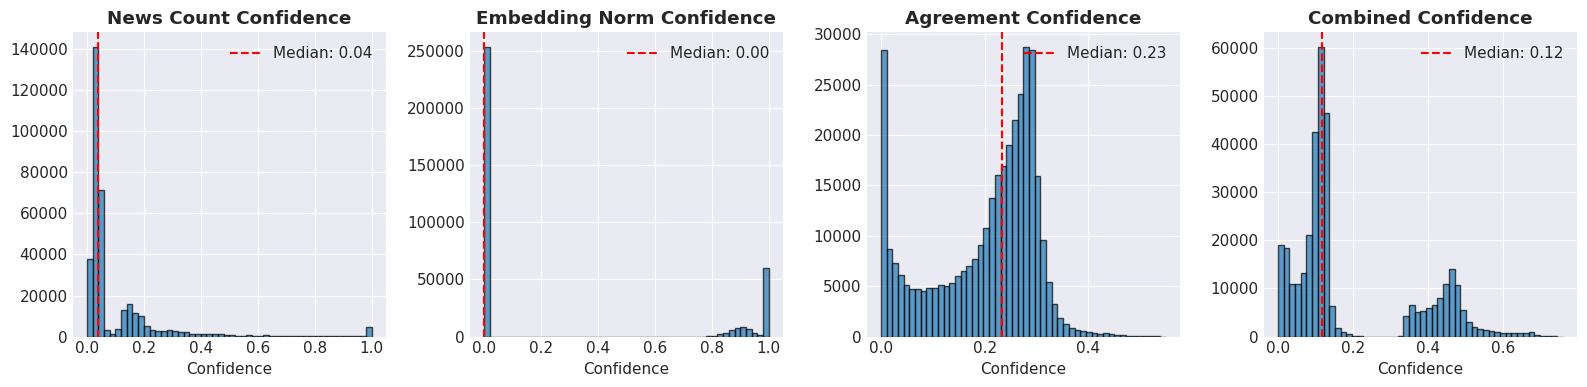

In [28]:
# Combined confidence score
# Weighted combination of components

def compute_confidence(
    df,
    w_news_count: float = 0.3,
    w_emb_norm: float = 0.3,
    w_agreement: float = 0.4,
):
    """Compute combined confidence score."""
    conf = (
        w_news_count * df["conf_news_count"] +
        w_emb_norm * df["conf_emb_norm"] +
        w_agreement * df["conf_agreement"]
    )
    return conf

test_df["confidence"] = compute_confidence(test_df)

print("Combined confidence score:")
print(test_df["confidence"].describe())

# Visualize confidence distribution
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, col, title in zip(
    axes,
    ["conf_news_count", "conf_emb_norm", "conf_agreement", "confidence"],
    ["News Count", "Embedding Norm", "Agreement", "Combined"]
):
    ax.hist(test_df[col], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(test_df[col].median(), color='red', linestyle='--', label=f'Median: {test_df[col].median():.2f}')
    ax.set_title(f"{title} Confidence", fontweight='bold')
    ax.set_xlabel("Confidence")
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Analyze Confidence vs Returns

In [29]:
# Does confidence predict better short performance?
# For shorts: we want low-score stocks. Does confidence help identify "true" losers?

# Bin by confidence and analyze
test_df["confidence_bin"] = pd.qcut(test_df["confidence"], q=5, labels=["Q1 (Low)", "Q2", "Q3", "Q4", "Q5 (High)"])
test_df["score_bin"] = pd.qcut(test_df["score"], q=5, labels=["Q1 (Worst)", "Q2", "Q3", "Q4", "Q5 (Best)"])

# For bottom quintile (shorts): how does confidence affect returns?
bottom_quintile = test_df[test_df["score_bin"] == "Q1 (Worst)"]

print("Bottom Score Quintile (Short Candidates):")
print("="*60)
conf_analysis = bottom_quintile.groupby("confidence_bin").agg({
    "target_return": ["mean", "std", "count"],
    "confidence": "mean"
}).round(4)
conf_analysis.columns = ["avg_return", "std_return", "count", "avg_conf"]
conf_analysis["short_pnl"] = -conf_analysis["avg_return"]  # Short P&L
print(conf_analysis)

print("\nKey insight: If high-confidence shorts have more negative returns,")
print("confidence gating should improve strategy.")

Bottom Score Quintile (Short Candidates):
                avg_return  std_return  count  avg_conf  short_pnl
confidence_bin                                                    
Q1 (Low)           -0.0049      0.0838  32623    0.0263     0.0049
Q2                 -0.0048      0.0595  10070    0.0918     0.0048
Q3                 -0.0025      0.0556   4986    0.1155     0.0025
Q4                 -0.0040      0.0657  14210    0.3326     0.0040
Q5 (High)          -0.0026      0.0651   8554    0.4887     0.0026

Key insight: If high-confidence shorts have more negative returns,
confidence gating should improve strategy.


/tmp/ipykernel_1318614/3944959304.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conf_analysis = bottom_quintile.groupby("confidence_bin").agg({


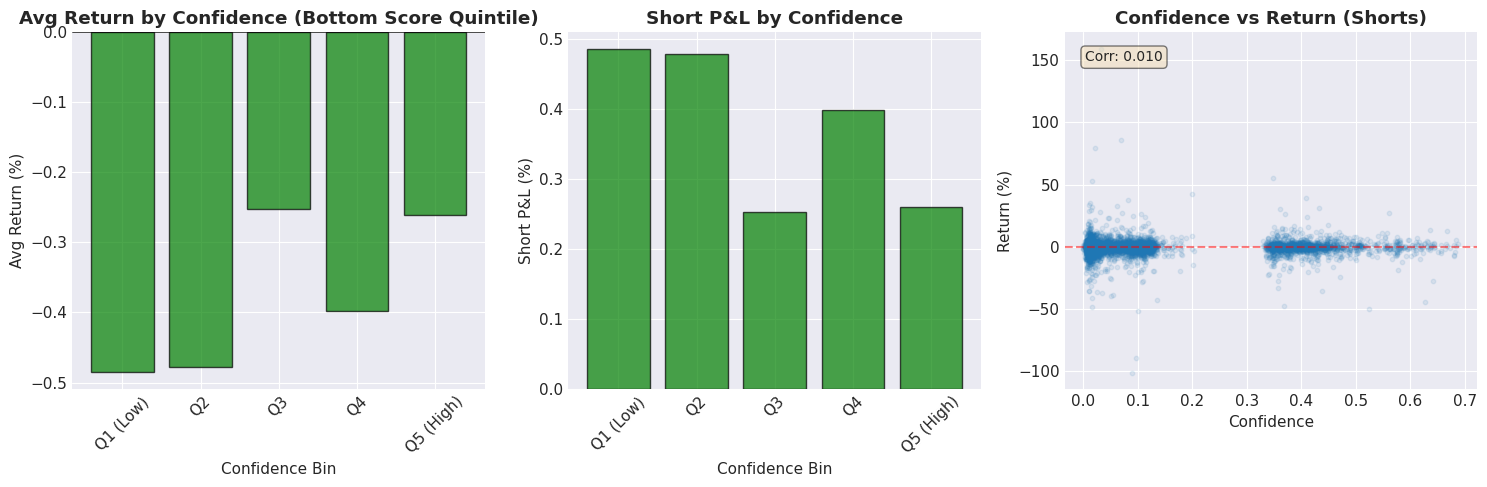

In [30]:
# Visualize confidence vs short performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Avg return by confidence bin (for shorts)
ax1 = axes[0]
conf_bins = ["Q1 (Low)", "Q2", "Q3", "Q4", "Q5 (High)"]
returns_by_conf = [bottom_quintile[bottom_quintile["confidence_bin"] == b]["target_return"].mean() * 100 
                   for b in conf_bins]
colors = ['green' if r < 0 else 'red' for r in returns_by_conf]
ax1.bar(conf_bins, returns_by_conf, color=colors, edgecolor='black', alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_title("Avg Return by Confidence (Bottom Score Quintile)", fontweight='bold')
ax1.set_xlabel("Confidence Bin")
ax1.set_ylabel("Avg Return (%)")
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Short P&L by confidence
ax2 = axes[1]
short_pnl = [-r for r in returns_by_conf]  # Negate for short P&L
colors = ['green' if p > 0 else 'red' for p in short_pnl]
ax2.bar(conf_bins, short_pnl, color=colors, edgecolor='black', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title("Short P&L by Confidence", fontweight='bold')
ax2.set_xlabel("Confidence Bin")
ax2.set_ylabel("Short P&L (%)")
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Scatter of confidence vs return
ax3 = axes[2]
sample = bottom_quintile.sample(min(5000, len(bottom_quintile)))
ax3.scatter(sample["confidence"], sample["target_return"] * 100, alpha=0.1, s=10)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.set_title("Confidence vs Return (Shorts)", fontweight='bold')
ax3.set_xlabel("Confidence")
ax3.set_ylabel("Return (%)")

# Add correlation
corr = bottom_quintile["confidence"].corr(bottom_quintile["target_return"])
ax3.text(0.05, 0.95, f"Corr: {corr:.3f}", transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 4. Backtest with Confidence Gating

In [31]:
# Load market cap for shortable universe
key_metrics = pd.read_parquet("data/key_metrics.pqt")
key_metrics["date"] = pd.to_datetime(key_metrics["date"])

latest_mcap = (
    key_metrics[["symbol", "date", "marketCap"]]
    .sort_values("date")
    .groupby("symbol")
    .last()
    .reset_index()
)

MIN_MCAP = 500_000_000
shortable_symbols = set(latest_mcap[latest_mcap["marketCap"] >= MIN_MCAP]["symbol"])
test_shortable = test_df[test_df["symbol"].isin(shortable_symbols)].copy()
print(f"Shortable universe: {len(test_shortable):,} rows")

Shortable universe: 334,455 rows


In [32]:
# Fee calculation
FEE_PER_SHARE = 0.005
MAX_FEE_PCT = 0.01
INITIAL_CAPITAL = 100_000

def calculate_fees(trade_value: float, price: float = 50.0) -> float:
    n_shares = trade_value / price if price > 0 else 0
    per_share_fee = n_shares * FEE_PER_SHARE
    max_fee = trade_value * MAX_FEE_PCT
    return min(per_share_fee, max_fee)


def run_confidence_gated_backtest(
    df: pd.DataFrame,
    bottom_k: int = 5,
    confidence_threshold: float = 0.0,  # Min confidence to trade
    size_by_confidence: bool = False,    # Size positions by confidence
    initial_capital: float = INITIAL_CAPITAL,
    clip_return: float = 0.50,
    include_fees: bool = True,
) -> pd.DataFrame:
    """
    Short strategy with confidence gating.
    
    Parameters:
    -----------
    confidence_threshold : float
        Only trade stocks with confidence >= threshold (0 = no filter)
    size_by_confidence : bool
        If True, size positions proportionally to confidence
    """
    results = []
    capital = initial_capital
    
    for date, group in df.groupby("feature_date"):
        if len(group) < bottom_k * 2:
            continue
        
        # Get bottom-K candidates by score
        candidates = group.nsmallest(bottom_k * 3, "score")  # Get extras for filtering
        
        # Apply confidence threshold
        if confidence_threshold > 0:
            candidates = candidates[candidates["confidence"] >= confidence_threshold]
        
        # Take top K after filtering
        shorts = candidates.nsmallest(min(bottom_k, len(candidates)), "score").copy()
        
        if len(shorts) == 0:
            # No trades this day
            results.append({
                "date": date,
                "pnl": 0,
                "return": 0,
                "capital": capital,
                "fees": 0,
                "n_positions": 0,
                "avg_confidence": 0,
                "skipped": True,
            })
            continue
        
        # Position sizing
        if size_by_confidence and len(shorts) > 0:
            # Size proportionally to confidence
            conf_weights = shorts["confidence"].values
            conf_weights = conf_weights / conf_weights.sum()  # Normalize
            position_sizes = capital * conf_weights
        else:
            # Equal weight
            position_sizes = np.full(len(shorts), capital / len(shorts))
        
        shorts["position_size"] = position_sizes
        
        # Calculate fees (entry + exit)
        if include_fees:
            total_fees = 2 * sum(calculate_fees(size) for size in position_sizes)
        else:
            total_fees = 0
        
        # Calculate P&L
        shorts["return_clipped"] = shorts["target_return"].clip(-clip_return, clip_return)
        shorts["pnl"] = -shorts["position_size"] * shorts["return_clipped"]  # Short P&L
        
        daily_pnl = shorts["pnl"].sum() - total_fees
        daily_return = daily_pnl / capital
        capital += daily_pnl
        
        results.append({
            "date": date,
            "pnl": daily_pnl,
            "return": daily_return,
            "capital": capital,
            "fees": total_fees,
            "n_positions": len(shorts),
            "avg_confidence": shorts["confidence"].mean(),
            "skipped": False,
        })
    
    return pd.DataFrame(results)

print("Confidence-gated backtest function defined")

Confidence-gated backtest function defined


In [33]:
def compute_metrics(results: pd.DataFrame) -> dict:
    """Compute performance metrics."""
    returns = results["return"]
    n_days = len(results)
    
    total_return = (results["capital"].iloc[-1] / INITIAL_CAPITAL - 1) * 100
    ann_return = ((1 + total_return/100) ** (252/n_days) - 1) * 100 if n_days > 0 else 0
    
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    sortino_denom = returns[returns < 0].std()
    sortino = returns.mean() / sortino_denom * np.sqrt(252) if sortino_denom > 0 else 0
    
    cumulative = (1 + returns).cumprod()
    max_dd = ((cumulative / cumulative.expanding().max()) - 1).min() * 100
    
    # Trading stats
    skipped_days = results["skipped"].sum() if "skipped" in results else 0
    avg_positions = results["n_positions"].mean()
    avg_confidence = results["avg_confidence"].mean() if "avg_confidence" in results else 0
    
    return {
        "total_return": total_return,
        "ann_return": ann_return,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_dd": max_dd,
        "win_rate": (returns > 0).mean() * 100,
        "total_fees": results["fees"].sum(),
        "skipped_days": skipped_days,
        "avg_positions": avg_positions,
        "avg_confidence": avg_confidence,
        "final_capital": results["capital"].iloc[-1],
    }

# Run strategy variants
strategies = {}

# 1. Baseline (no gating)
results = run_confidence_gated_backtest(
    test_shortable, bottom_k=5, 
    confidence_threshold=0, size_by_confidence=False
)
strategies["Baseline (no gating)"] = {"results": results, "metrics": compute_metrics(results)}

# 2. Confidence threshold variants (adjusted for 0.05-0.3 range)
for threshold in [0.10, 0.15, 0.20, 0.25]:
    name = f"Threshold {threshold:.2f}"
    results = run_confidence_gated_backtest(
        test_shortable, bottom_k=5,
        confidence_threshold=threshold, size_by_confidence=False
    )
    strategies[name] = {"results": results, "metrics": compute_metrics(results)}

# 3. Confidence-weighted sizing
results = run_confidence_gated_backtest(
    test_shortable, bottom_k=5,
    confidence_threshold=0, size_by_confidence=True
)
strategies["Conf-weighted sizing"] = {"results": results, "metrics": compute_metrics(results)}

# 4. Combined: threshold + sizing
for threshold in [0.10, 0.15]:
    name = f"Threshold {threshold:.2f} + sizing"
    results = run_confidence_gated_backtest(
        test_shortable, bottom_k=5,
        confidence_threshold=threshold, size_by_confidence=True
    )
    strategies[name] = {"results": results, "metrics": compute_metrics(results)}

print(f"Tested {len(strategies)} strategy variants")

Tested 8 strategy variants


In [34]:
# Summary table
comparison_df = pd.DataFrame({
    name: strat["metrics"] for name, strat in strategies.items()
}).T

comparison_df = comparison_df.round(2)
comparison_df["final_capital"] = comparison_df["final_capital"].apply(lambda x: f"${x:,.0f}")
comparison_df["total_fees"] = comparison_df["total_fees"].apply(lambda x: f"${x:,.0f}")

comparison_df = comparison_df.sort_values("sharpe", ascending=False)

print("=" * 100)
print("CONFIDENCE GATING COMPARISON")
print("=" * 100)

display_cols = ["sharpe", "total_return", "max_dd", "win_rate", "skipped_days", "avg_positions", "avg_confidence", "final_capital"]
print(comparison_df[display_cols].to_string())

print("\n" + "=" * 100)
baseline_sharpe = strategies["Baseline (no gating)"]["metrics"]["sharpe"]
best_name = comparison_df.index[0]
best_sharpe = comparison_df.loc[best_name, "sharpe"]
print(f"Baseline Sharpe: {baseline_sharpe:.2f}")
print(f"Best Strategy: {best_name} (Sharpe={best_sharpe:.2f})")
print(f"Improvement: {best_sharpe - baseline_sharpe:+.2f}")

CONFIDENCE GATING COMPARISON
                         sharpe  total_return  max_dd  win_rate  skipped_days  avg_positions  avg_confidence final_capital
Baseline (no gating)       1.92        150.49  -45.78     53.93           0.0            5.0            0.29      $250,485
Threshold 0.10 + sizing    0.42          2.16  -57.38     52.81           0.0            5.0            0.40      $102,162
Threshold 0.10             0.38          0.81  -57.87     52.25           0.0            5.0            0.40      $100,807
Conf-weighted sizing       0.36         -3.84  -65.63     52.81           0.0            5.0            0.29       $96,161
Threshold 0.15 + sizing    0.35         -1.07  -57.70     52.81           0.0            5.0            0.41       $98,929
Threshold 0.20             0.32         -1.92  -58.16     53.37           0.0            5.0            0.41       $98,076
Threshold 0.25             0.32         -1.92  -58.16     53.37           0.0            5.0            0.41  

## 5. Visualize Results

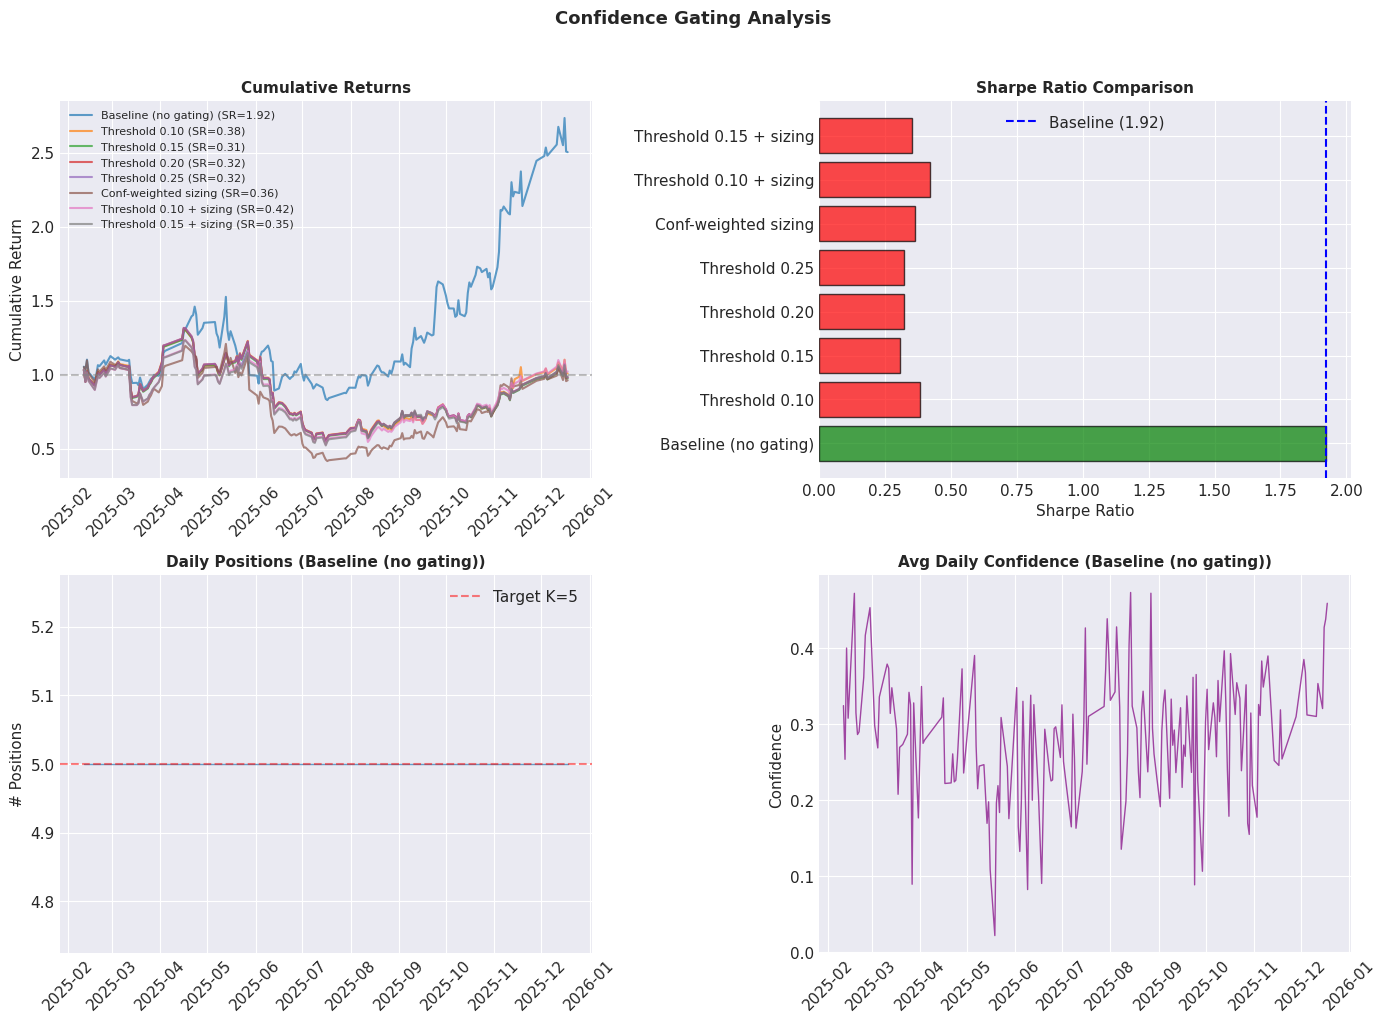

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative returns
ax1 = axes[0, 0]
for name, strat in strategies.items():
    results = strat["results"]
    cum_ret = (1 + results["return"]).cumprod()
    ax1.plot(results["date"], cum_ret, label=f'{name} (SR={strat["metrics"]["sharpe"]:.2f})', alpha=0.7)
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_title("Cumulative Returns", fontsize=11, fontweight='bold')
ax1.set_ylabel("Cumulative Return")
ax1.legend(fontsize=8, loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Sharpe comparison
ax2 = axes[0, 1]
names = list(strategies.keys())
sharpes = [strategies[n]["metrics"]["sharpe"] for n in names]
colors = ['green' if s >= baseline_sharpe else 'red' for s in sharpes]
bars = ax2.barh(names, sharpes, color=colors, edgecolor='black', alpha=0.7)
ax2.axvline(x=baseline_sharpe, color='blue', linestyle='--', label=f'Baseline ({baseline_sharpe:.2f})')
ax2.set_title("Sharpe Ratio Comparison", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sharpe Ratio")
ax2.legend()

# Plot 3: Daily positions over time (best strategy)
ax3 = axes[1, 0]
best_results = strategies[best_name]["results"]
ax3.plot(best_results["date"], best_results["n_positions"], linewidth=1, alpha=0.7)
ax3.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Target K=5')
ax3.set_title(f"Daily Positions ({best_name})", fontsize=11, fontweight='bold')
ax3.set_ylabel("# Positions")
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Confidence over time (best strategy)
ax4 = axes[1, 1]
ax4.plot(best_results["date"], best_results["avg_confidence"], linewidth=1, alpha=0.7, color='purple')
ax4.set_title(f"Avg Daily Confidence ({best_name})", fontsize=11, fontweight='bold')
ax4.set_ylabel("Confidence")
ax4.tick_params(axis='x', rotation=45)

plt.suptitle("Confidence Gating Analysis", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("data/confidence_gating_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary

In [36]:
print("=" * 80)
print("CONFIDENCE GATING SUMMARY")
print("=" * 80)

print("\n--- Confidence Score Components ---")
print("1. News Count: More news articles = higher confidence")
print("2. Embedding Norm: Stronger embedding = clearer signal")
print("3. Agreement: News-fundamentals alignment = more reliable")

print("\n--- Strategy Results ---")
print(f"Baseline Sharpe: {baseline_sharpe:.2f}")
print(f"Best Strategy: {best_name}")
print(f"Best Sharpe: {best_sharpe:.2f}")
print(f"Improvement: {best_sharpe - baseline_sharpe:+.2f}")

best_metrics = strategies[best_name]["metrics"]
print(f"\n--- Best Strategy Details ---")
print(f"Total Return: {best_metrics['total_return']:.1f}%")
print(f"Max Drawdown: {best_metrics['max_dd']:.1f}%")
print(f"Win Rate: {best_metrics['win_rate']:.1f}%")
print(f"Skipped Days: {best_metrics['skipped_days']:.0f}")
print(f"Avg Confidence: {best_metrics['avg_confidence']:.2f}")

# Key insight
if best_sharpe > baseline_sharpe:
    print("\n>>> Confidence gating IMPROVES performance!")
    print("    Higher confidence trades have better outcomes.")
else:
    print("\n>>> Confidence gating does NOT improve performance.")
    print("    The confidence signal may not capture useful information.")

CONFIDENCE GATING SUMMARY

--- Confidence Score Components ---
1. News Count: More news articles = higher confidence
2. Embedding Norm: Stronger embedding = clearer signal
3. Agreement: News-fundamentals alignment = more reliable

--- Strategy Results ---
Baseline Sharpe: 1.92
Best Strategy: Baseline (no gating)
Best Sharpe: 1.92
Improvement: -0.00

--- Best Strategy Details ---
Total Return: 150.5%
Max Drawdown: -45.8%
Win Rate: 53.9%
Skipped Days: 0
Avg Confidence: 0.29

>>> Confidence gating does NOT improve performance.
    The confidence signal may not capture useful information.


In [37]:
# Save results
comparison_df.to_csv("data/confidence_gating_comparison.csv")
strategies[best_name]["results"].to_parquet("data/confidence_gating_best.pqt", index=False)

# Save confidence scores for use in live trading
test_shortable[["symbol", "feature_date", "score", "confidence", 
                "conf_news_count", "conf_emb_norm", "conf_agreement"]].to_parquet(
    "data/confidence_scores.pqt", index=False
)

print("\nSaved:")
print("  - data/confidence_gating_comparison.csv")
print("  - data/confidence_gating_best.pqt")
print("  - data/confidence_scores.pqt")
print("  - data/confidence_gating_comparison.png")


Saved:
  - data/confidence_gating_comparison.csv
  - data/confidence_gating_best.pqt
  - data/confidence_scores.pqt
  - data/confidence_gating_comparison.png
